In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor

path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config.toml"
empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


String[]

Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [12]:
#@suppress begin 
    mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
    kG = kGrids[1]
    qG = qGrids[1]
    νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);
#end;

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:107
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│   sp: 11
│   ch: 11 
│   χLoc_sp = 0.2694, χLoc_ch = 0.093
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:148


# Potential Issues

## Issue 1: Frequency fits impact tail of trilex

There seems to be some sort of error compensation when inverting $\Gamma$ and extrapolating the $\nu$ sum for $\chi$.

In [15]:
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);

Internal code for the `calc_χ_trilex` function:

In [42]:
using SharedArrays
using Distributed
using GenericLinearAlgebra
using LinearAlgebra

# emulate function parameters and namespace
Γr = impQ_sp.Γ
U = mP.U
sum_freq = LadderDGA.sum_freq
sumHelper = sumHelper_f
kintegrate = LadderDGA.kintegrate
kGrid = qG
find_usable_interval = LadderDGA.find_usable_interval
sumHelper_ν_nc = LadderDGA.Naive()
sumHelper_ν_rc = LadderDGA.Richardson(LadderDGA.default_fit_range(size(bubble,3)), [0,1,2,3,4])
indh = ceil(Int64, size(bubble,1)/2) + 5

# function starts here
χ_nc = SharedArray{eltype(bubble), 2}((size(bubble)[1:2]...))
γ_nc = SharedArray{eltype(bubble), 3}((size(bubble)...))
χ_rc = SharedArray{eltype(bubble), 2}((size(bubble)[1:2]...))
γ_rc = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_tmp_nc = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_tmp_rc = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_mix1 = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_mix2 = SharedArray{eltype(bubble), 3}((size(bubble)...))
χ_ω = SharedArray{eltype(bubble), 1}(size(bubble)[1]) 
ωindices = 1:size(bubble,1)
νIndices = 1:size(bubble,3);

In [43]:
# compute quantities
for ωi in indh
    Γview = view(Γr,ωi,νIndices,νIndices)
    UnitM = Matrix{eltype(Γr)}(I, length(νIndices),length(νIndices))
    for qi in 1:size(bubble, 2)
        bubble_i = view(bubble,ωi, qi, νIndices)
        bubbleD = Diagonal(bubble_i)
        χ_full = (bubbleD * Γview + UnitM)\bubbleD
        χ_nc[ωi, qi] = sum_freq(χ_full, [1,2], sumHelper_ν_nc, mP.β)[1,1]
        χ_rc[ωi, qi] = sum_freq(χ_full, [1,2], sumHelper_ν_rc, mP.β)[1,1]
        γ_nc[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_nc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_nc[ωi, qi]))
        γ_rc[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_rc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_rc[ωi, qi]))
        γ_tmp_nc[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_nc, 1.0)[1,:]
        γ_tmp_rc[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_rc, 1.0)[1,:]
        γ_mix1[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_rc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_nc[ωi, qi]))
        γ_mix2[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_nc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_rc[ωi, qi]))
        χ_ω[ωi] = kintegrate(kGrid, χ_nc[ωi,:])[1]
    end
end
usable = find_usable_interval(real(χ_ω))

21:21

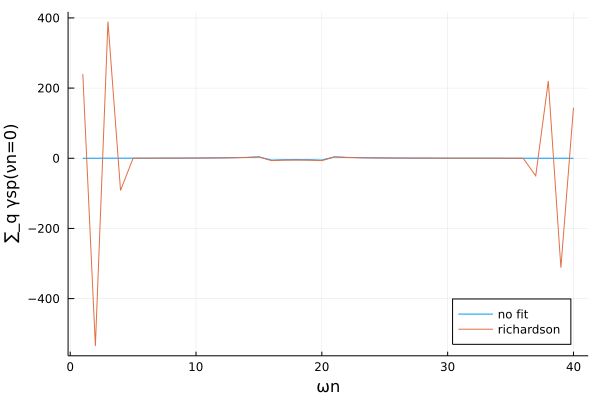

In [49]:
plot(real(γ_tmp_nc[indh,end,:]), label="no fit", ylabel="∑_q γsp(νn=0)", xlabel="ωn", legend=:bottomright)
plot!(real(γ_tmp_rc[indh,1,:]), label="richardson")

In [44]:
# prepare data for plots
χ_nc = real.(χ_nc)
χ_rc = real.(χ_rc)
χ_nc_ω = kintegrate(qG,χ_nc, dim=2)
χ_rc_ω = kintegrate(qG,χ_rc, dim=2)
χ_rc[abs.(χ_rc) .> maximum(χ_rc[indh,:])] .= 0;

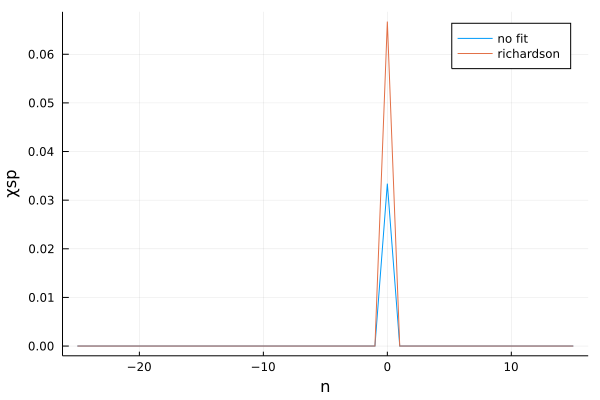

In [45]:
# This shows the q = (pi,pi) spin susceptibility (qG.kGrid contains the k vector for each index)
plot(ωindices .- indh, real(χ_nc[:,end]), label="no fit", ylabel="χsp", xlabel="n")
plot!(ωindices .- indh, real(χ_rc[:,end]), label="richardson")

In [24]:
# prepare data for plots
γ_nc_ων  = real.(kintegrate(qG,γ_nc, dim=2))
γ_rc_ων = real.(kintegrate(qG,γ_rc, dim=2))
γ_mix1_ων = real.(kintegrate(qG,γ_mix1, dim=2))
γ_mix2_ων = real.(kintegrate(qG,γ_mix2, dim=2));
println("maximum imaginary part. naive: $(maximum(imag(γ_nc))), richardson: $(maximum(imag(γ_rc))), mix1: $(maximum(imag(γ_mix1))), mix2: $(maximum(imag(γ_mix2)))")

maximum imaginary part. naive: 0.1294024031218757, richardson: 0.17036664042639865, mix1: 0.1771132681685841, mix2: 0.1244730541873217


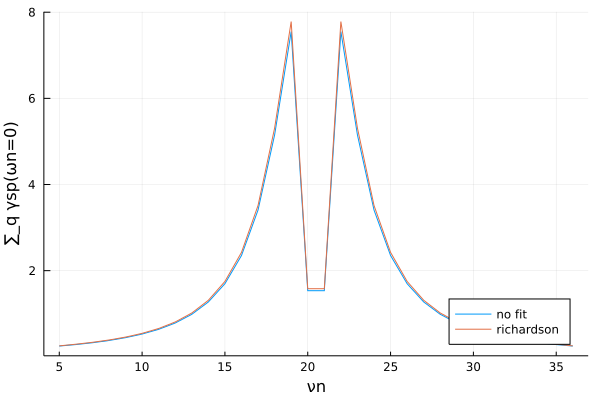

In [26]:
wind = indh
slice = 5:36
plot(νIndices[slice], real(γ_tmp_nc[wind,end,slice]), label="no fit", ylabel="∑_q γsp(ωn=$(wind-indh))", xlabel="νn", legend=:bottomright)
plot!(νIndices[slice], real(γ_tmp_rc[wind,end,slice]), label="richardson")

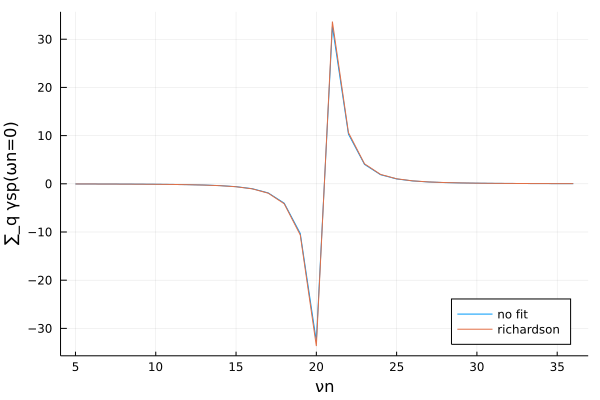

In [27]:
wind = indh
slice = 5:36
plot(νIndices[slice], imag(γ_tmp_nc[wind,end,slice]), label="no fit", ylabel="∑_q γsp(ωn=$(wind-indh))", xlabel="νn", legend=:bottomright)
plot!(νIndices[slice], imag(γ_tmp_rc[wind,end,slice]), label="richardson")

In [28]:
display((γ_tmp_nc[wind,end,slice] .- γ_tmp_rc[wind,end,slice])./(γ_tmp_nc[wind,end,slice]))

32-element Vector{ComplexF64}:
  -0.01809011513327284 - 0.0015269335113255473im
 -0.029163688373791945 - 0.0002809172543439359im
 -0.030478239428178067 - 6.649616430607615e-5im
 -0.030672168940188323 - 1.6507638541681356e-5im
 -0.030714181302954432 - 2.1390173076648836e-6im
 -0.030731670027266397 + 2.847866620789098e-6im
 -0.030732867206789995 + 3.169428252422766e-6im
  -0.03074326918536714 + 2.7885173109259857e-6im
 -0.030740397531521847 + 1.8252919904424388e-6im
  -0.03074677560759439 + 1.7214510511388977e-6im
 -0.030746427204019856 + 3.993063508186856e-7im
  -0.03075163886206429 + 1.429181447284723e-6im
  -0.03075532201702531 + 1.2066341554086957e-6im
                       ⋮
 -0.030751638862007477 - 1.4292882152646541e-6im
 -0.030746427204729886 - 3.9941684630057e-7im
 -0.030746775607534055 - 1.72156013026588e-6im
 -0.030740397531165527 - 1.8254323986653278e-6im
  -0.03074326918498605 - 2.788640496138645e-6im
 -0.030732867206742096 - 3.169595373966302e-6im
 -0.030731670028066982 - 

In [31]:
find_usable_interval(γ_rc_ων[wind,end,:])

20:21

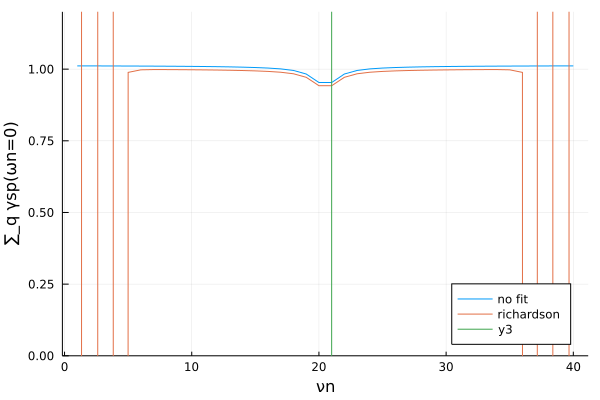

In [38]:
wind = indh
νindh = ceil(Int64, size(γ_nc_ων,3)/2) + 1
plot(νIndices, real(γ_nc_ων[wind,1,:]), label="no fit", ylabel="∑_q γsp(ωn=$(wind-indh))", xlabel="νn", legend=:bottomright, ylims=(0,1.2))
plot!(νIndices, real(γ_rc_ων[wind,1,:]), label="richardson")
#plot!(νIndices .- indh, real(γ_mix1_ων[wind,end,:]), label="mix1")
#plot!(νIndices .- indh, real(γ_mix2_ων[wind,end,:]), label="mix2")
vline!([νindh])